<a href="https://colab.research.google.com/github/ksairos/tf-advanced-techniques-course/blob/main/course_4/C4_W3_Lab_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Variational AutoEncoder

Using Variational AutoEncoder on MNIST dataset to generate new images of digits

## Imports|

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from IPython import display

K = tf.keras.backend

## Parameters

In [2]:
BATCH_SIZE = 128
LATENT_DIM = 2

## Prepare Dataset

In [3]:
# Utilities

def map_image(image, label):
  '''returns a normalized and reshaped tensor from a given image'''
  image = tf.cast(image, dtype=tf.float32)
  image = image / 255.0
  image = tf.reshape(image, shape=(28, 28, 1,))
  
  return image


def get_dataset(map_fn, is_validation=False):
  '''Loads and prepares the mnist dataset from TFDS.'''
  if is_validation:
    split_name = "test"
  else:
    split_name = "train"

  dataset = tfds.load('mnist', as_supervised=True, split=split_name)
  dataset = dataset.map(map_fn)
  
  if is_validation:
    dataset = dataset.batch(BATCH_SIZE)
  else:
    dataset = dataset.shuffle(1024).batch(BATCH_SIZE)

  return dataset

In [4]:
train_dataset = get_dataset(map_image)
valid_dataset = get_dataset(map_image, is_validation=True)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



Dl Completed...:   0%|          | 0/4 [00:00<?, ? file/s]


Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


## Build the model

<img src="https://drive.google.com/uc?export=view&id=1YAZAeMGEJ1KgieYk1ju-S9DoshpMREeC" width="60%" height="60%"/>

Architecture of VAE is similar to general auto-encoders with main difference in latent representation. It takes output of the encoder and mixes it with a random sample, letting us generate something new.

### Sampling Class

Custom layer that defines a gray box in the diagram

In [5]:
class Sampling(tf.keras.layers.Layer):
  def call(self, input):
    """Generates a random sample and combines with the encoder output

    Args:
      inputs -- output tensor from the encoder

    Returns:
      `inputs` tensors combined with a random sample
    """

    # unpack the output of the encoder 
    mu, sigma = input

    # get the size and dimentions of the batch
    batch = tf.shape(mu)[0]
    dim = tf.shape(mu)[1]

    # generate a random tensor
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))

    # mix the inputs and generated noise
    return mu + tf.exp(0.5 * sigma) * epsilon

### Encoder

<img src="https://drive.google.com/uc?export=view&id=1eoxFK_UVSHd3a_5EHcCU8F8QDZlPiXfW" width="60%" height="60%"/>

In [6]:
from keras.layers import Dense, Conv2D, BatchNormalization, Flatten, Input, Reshape, Conv2DTranspose

def encoder_layers(inputs, latent_dim):
  """Defines the encoder's layers.
  Args:
    inputs -- batch from the dataset
    latent_dim -- dimensionality of the latent space

  Returns:
    mu -- learned mean
    sigma -- learned standard deviation
    batch_2.shape -- shape of the features before flattening
  """ 

  # Conv2D layers followed by BatchNormalization layers
  x = Conv2D(filters=32, kernel_size=3, strides=2, padding='same', activation='relu', name='encoder_conv1')(inputs)
  x = BatchNormalization()(x)
  x = Conv2D(filters=64, kernel_size=3, strides=2, padding='same', activation='relu', name='encoder_conv2')(x)

  # this will be our third output
  batch_2 = BatchNormalization()(x)

  # Flatten before feeding to Dense layer
  x = Flatten(name="encoder_flatten")(batch_2)

  # Dense layer
  x = Dense(20, activation='relu', name='encoder_dense')(x)
  x = BatchNormalization()(x)

  # Dense layers for mu and sigma with latent_dim units
  mu = Dense(latent_dim, name='latent_mu')(x)
  sigma = Dense(latent_dim, name='latent_sigma')(x)

  return mu, sigma, batch_2.shape

In [7]:
def encoder_model(latent_dim, input_shape):
  """Defines the encoder model with the Sampling layer
  Args:
    latent_dim -- dimensionality of the latent space
    input_shape -- shape of the dataset batch

  Returns:
    model -- the encoder model
    conv_shape -- shape of the features before flattening
  """

  # input layer
  inputs = Input(shape=input_shape)

  # get the output of encoder layers
  mu, sigma, conv_shape = encoder_layers(inputs, latent_dim)

  # feed mu and sigma to Sampling layer
  z = Sampling()((mu, sigma))

  # build encoder model
  model = tf.keras.Model(inputs=inputs, outputs=[mu, sigma, z])

  return model, conv_shape

In [8]:
K.clear_session()

tmp_encoder, _ = encoder_model(LATENT_DIM, (28, 28, 1))
tmp_encoder.summary()

del tmp_encoder

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 encoder_conv1 (Conv2D)         (None, 14, 14, 32)   320         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 14, 14, 32)  128         ['encoder_conv1[0][0]']          
 alization)                                                                                       
                                                                                                  
 encoder_conv2 (Conv2D)         (None, 7, 7, 64)     18496       ['batch_normalization[0][0]']

### Decoder
This part of the model expands latent representations back to original size image. It will resemble training data

In [9]:
def decoder_layers(inputs, conv_shape):
  """Defines the decoder layers.
  Args:
    inputs -- output of the encoder 
    conv_shape -- shape of the features before flattening

  Returns:
    tensor containing the decoded output
  """

  # Compute number of units from conv_shape dimentions and create a Dense layer
  units = conv_shape[1] * conv_shape[2] * conv_shape[3]
  x = Dense(units, activation='relu', name='decoder_dense')(inputs)
  x = BatchNormalization()(x)

  # Reshape resulting dense layer into conv_shape
  x = Reshape((conv_shape[1], conv_shape[2], conv_shape[3]), name="decoder_reshape")(x)

  # Upsample back to original size with deconvolutional layers
  x = Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same', activation='relu', name='decoder_deconv2d_1')(x)
  x = BatchNormalization()(x)
  x = Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same', activation='relu', name='decoder_deconv2d_2')(x)
  x = BatchNormalization()(x)
  x = Conv2DTranspose(filters=1, kernel_size=3, strides=1, padding='same', activation='relu', name='decoder_deconv2d_final')(x)

  return x

In [10]:
def decoder_model(latent_dim, conv_shape):
  """Defines the decoder model.
  Args:
    latent_dim -- dimensionality of the latent space
    conv_shape -- shape of the features before flattening

  Returns:
    model -- the decoder model
  """

  inputs = Input(shape=(latent_dim, ))

  outputs = decoder_layers(inputs, conv_shape)

  model = tf.keras.Model(inputs=inputs, outputs=outputs)

  return model

In [11]:
K.clear_session()

tmp_decoder = decoder_model(LATENT_DIM, (None, 7, 7, 64))
tmp_decoder.summary()

del tmp_decoder

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2)]               0         
                                                                 
 decoder_dense (Dense)       (None, 3136)              9408      
                                                                 
 batch_normalization (BatchN  (None, 3136)             12544     
 ormalization)                                                   
                                                                 
 decoder_reshape (Reshape)   (None, 7, 7, 64)          0         
                                                                 
 decoder_deconv2d_1 (Conv2DT  (None, 14, 14, 64)       36928     
 ranspose)                                                       
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 64)       256   

### Kullback–Leibler Divergence
We add Kullback–Leibler Divergence to our reconstruction loss in order to improve generative capabilities of our model

In [12]:
def kl_reconstruction_loss(inputs, outputs, mu, sigma):
  """ Computes the Kullback-Leibler Divergence (KLD)
  Args:
    inputs -- batch from the dataset
    outputs -- output of the Sampling layer
    mu -- mean
    sigma -- standard deviation

  Returns:
    KLD loss
  """
  kl_loss = 1 + sigma - tf.square(mu) - tf.math.exp(sigma)
  kl_loss = tf.reduce_mean(kl_loss) * -0.5
  
  return kl_loss

### Define Entire VAE Model

In [13]:
def vae_model(encoder, decoder, input_shape):
  """Defines the VAE model
  Args:
    encoder -- the encoder model
    decoder -- the decoder model
    input_shape -- shape of the dataset batch

  Returns:
    the complete VAE model
  """

  # input
  inputs = Input(input_shape)
  
  # encoder outputs
  mu, sigma, z = encoder(inputs)

  # reconstructed output from the decoder   
  reconstructed = decoder(z)

  # define the model
  model = tf.keras.Model(inputs=inputs, outputs=reconstructed)

  # add the KL loss 
  loss = kl_reconstruction_loss(inputs, z, mu, sigma)
  model.add_loss(loss)

  return model

Finally, the function that combines everything we were writing

In [14]:
def get_models(input_shape, latent_dim):
  """Returns the encoder, decoder, and vae models"""
  encoder, conv_shape = encoder_model(latent_dim, input_shape)
  decoder = decoder_model(latent_dim, conv_shape)
  vae = vae_model(encoder, decoder, input_shape)
  
  return encoder, decoder, vae

In [15]:
K.clear_session()

encoder, decoder, vae = get_models(input_shape=(28,28,1), latent_dim=LATENT_DIM)

In [16]:
vae.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 model (Functional)             [(None, 2),          82104       ['input_3[0][0]']                
                                 (None, 2),                                                       
                                 (None, 2)]                                                       
                                                                                                  
 model_1 (Functional)           (None, 28, 28, 1)    78017       ['model[0][2]']                  
                                                                                            

## Train the model

In [17]:
# Model parameters

optimizer = tf.keras.optimizers.Adam()
loss_metric = tf.keras.metrics.Mean()
bce_loss = tf.keras.losses.BinaryCrossentropy()

Helper function to see the progress of the model at the end of every epoch

In [18]:
def generate_and_save_images(model, epoch, step, test_input):
  """Helper function to plot our 16 images

  Args:

  model -- the decoder model
  epoch -- current epoch number during training
  step -- current step number during training
  test_input -- random tensor with shape (16, LATENT_DIM)
  """

  # generate images from the test input
  predictions = model.predict(test_input)

  # plot the results
  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0], cmap='gray')
      plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  fig.suptitle("epoch: {}, step: {}".format(epoch, step))
  plt.savefig('image_at_epoch_{:04d}_step{:04d}.png'.format(epoch, step))
  plt.show()

### Training Loop

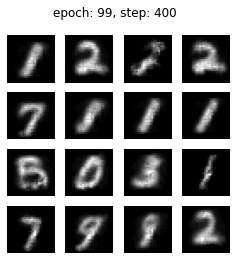

Epoch: 99 step: 400 mean loss = 153.81007


In [19]:
# generate random vector as test input to the decoder
random_vector_for_generation = tf.random.normal(shape=[16, LATENT_DIM])

# number of epochs
epochs = 100

# initialize the helper function to display outputs from an untrained model
generate_and_save_images(decoder, 0, 0, random_vector_for_generation)

for epoch in range(epochs):
  print('Start of epoch %d' % (epoch,))

  # iterate over batches
  for step, x_batch_train in enumerate(train_dataset):
    
    with tf.GradientTape() as tape:

      # feed a batch to the VAE model
      reconstructed = vae(x_batch_train)

      # compute reconstruction loss
      flattened_inputs = tf.reshape(x_batch_train, shape=[-1])
      flattened_outputs = tf.reshape(reconstructed, shape=[-1])
      loss = bce_loss(flattened_inputs, flattened_outputs) * 784

      # add KLD regularization loss
      loss += sum(vae.losses)

    # get gradient and update weights
    grads = tape.gradient(loss, vae.trainable_weights)
    optimizer.apply_gradients(zip(grads, vae.trainable_weights))

    # compute the loss metric
    loss_metric(loss)

    # display outputs every 100 steps
    if step % 100 == 0:
      display.clear_output(wait=False)
      generate_and_save_images(decoder, epoch, step, random_vector_for_generation)
      print('Epoch: %s step: %s mean loss = %s' % (epoch, step, loss_metric.result().numpy()))

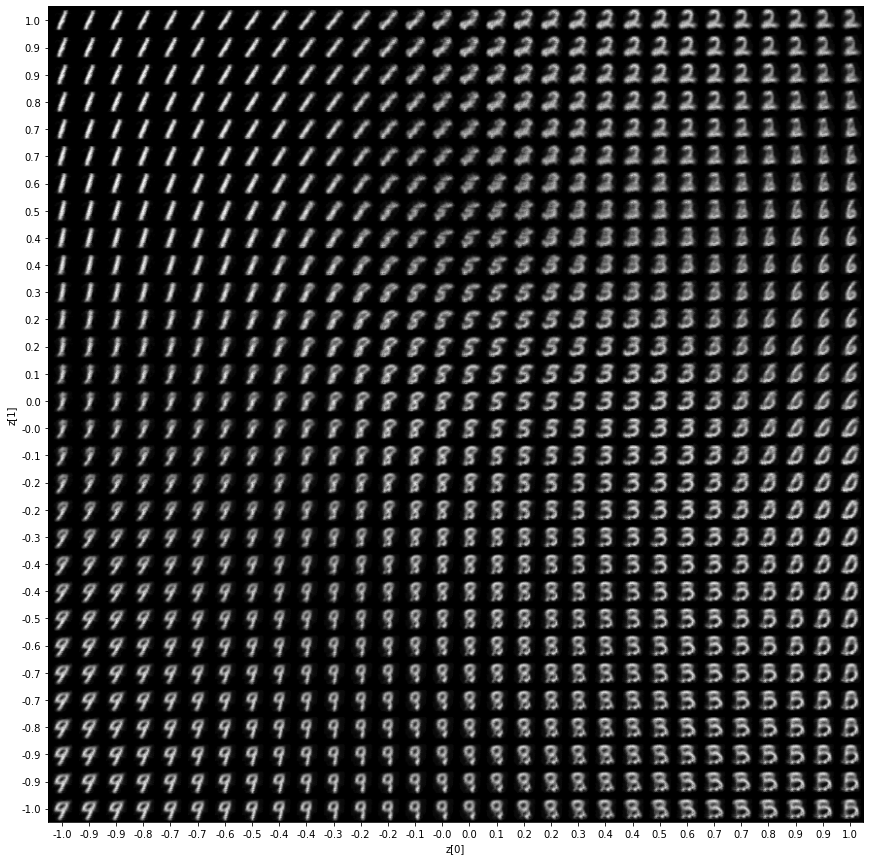

In [22]:
import matplotlib.pyplot as plt
import numpy as np

def plot_latent_space(vae, n=30, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 28
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(vae)